In [151]:
import pandas as pd 
from typing import List, Dict, Any
import numpy as np



In [152]:
exp1 = "../results/ALL_complete_meaningful_2.csv"
exp2 = "../results/ALL_complete_meaningful.csv"
exp3 = "../results/Baseline_20_meaningful.csv"
exp4 = "../results/Baseline_20_random.csv"
exp5 = "../results/SGD_20_random.csv"
exp6 = "../results/SGD_complete_meaningful.csv"

In [153]:
df1 = pd.read_csv(exp1)
df2 = pd.read_csv(exp2)
df3 = pd.read_csv(exp3)
df4 = pd.read_csv(exp4)
df5 = pd.read_csv(exp5)
df6 = pd.read_csv(exp6)

df1['dataset_type'] = 'meaningful'
df2['dataset_type'] = 'meaningful'

df3['optimizer'] = 'baseline'
df4['optimizer'] = 'baseline'

df3['dataset_type'] = 'meaningful'
df4['dataset_type'] = 'random'

df5['dataset_type'] = 'random'
df6['dataset_type'] = 'meaningful'

df = pd.concat([df1, df2, df3, df4, df5, df6], axis=0)

In [154]:
def compute_statistics(
    df: pd.DataFrame, 
    column_name: str = "timesteps", 
    indices: List[int] = [10],
    reduce: str = 'mean'
):
    assert column_name in ["timesteps", "times"], "Choises for `column_name`: ['timesteps', 'times']."
    
    reduction = (lambda x: np.mean(x)) if reduce == 'mean' else (lambda x: np.sum(x))

    column = df[column_name]
    scores = column.apply(lambda x: list(float(i) for i in x.split("_")))

    scores = [
        scores.apply(lambda x: reduction(x[:i + 1]))
        for i in indices
    ]

    return [
        (x.mean(), x.std())
        for x in scores
    ]

### Plotting

In [155]:
import sys
sys.path.append('..')

from utils.constants import COLORS

import matplotlib.pyplot as plt
import numpy as np
import shutil
from utils.metrics import _agg_metric

# Define a custom color palette (Slate Gray replaces Eggshell)
color_dict = {
    "Slate Gray": "#708090",
    "Burnt sienna": "#e07a5f",
    "Delft Blue": "#3d405b",
    "Cambridge blue": "#81b29a",
    "Sunset": "#f2cc8f",
}
# Styles order: darker hues first
STYLES = [
    color_dict["Delft Blue"],
    color_dict["Cambridge blue"],
    color_dict["Burnt sienna"],
    color_dict["Sunset"],
    color_dict["Slate Gray"],
]

# Check for LaTeX availability and configure text rendering
usetex_available = shutil.which('latex') is not None
plt.rcParams['text.usetex'] = usetex_available
if not usetex_available:
    plt.rcParams['text.usetex'] = False
    print("Warning: LaTeX not found, falling back to Matplotlib mathtext.")

# Global style settings
plt.rcParams.update({
    "font.family": "serif",
    "axes.titlesize": 24,
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 16,  # smaller legend font
})

def _rename(name: str, rename_dict: dict = None) -> str:
    """
    Rename a metric name based on a provided dictionary.
    """
    return rename_dict.get(name, name) if rename_dict else name


def plot_metrics(
    metrics,
    fill_between: bool = True,
    rename: dict = None,
    xlabel: str = None,
    ylabel: str = None,
    title: str = None,
    figsize: tuple = (12, 8),  # taller plot
    integer_xticks: bool = False,
    y_logscale: bool = False,
    xticks: list = None,
    yticks: list = None
):
    """
    Plot aggregated metrics per layer with a consistent, publication-quality style.
    """
    agg_metrics = {m: _agg_metric(metrics, m) for m in metrics}
    fig, ax = plt.subplots(figsize=figsize)

    for i, (metric_name, (mean, std)) in enumerate(agg_metrics.items()):
        x = np.arange(len(mean))
        color = STYLES[i % len(STYLES)]
        if fill_between:
            ax.fill_between(x, mean - std, mean + std, alpha=0.2, color=color)
        ax.plot(x, mean,
                label=_rename(metric_name, rename),
                color=color,
                marker='o',
                markersize=8,
                linewidth=2)

    # Axis labels and title
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    if title:
        ax.set_title(title, fontsize=24)

    if y_logscale:
        ax.set_yscale('log')

    # Tick customization
    ax.tick_params(axis='x', labelsize=16)
    if integer_xticks:
        ax.set_xticks(x)
        ax.set_xticklabels([str(i + 1) for i in x], fontsize=16)
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)

    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Smaller, centered legend
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(agg_metrics),
        frameon=False,
        fontsize=14
    )

    # Adjust layout to center axes and prevent clipping
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.25, top=0.9)
    plt.show()

### Experiments 8.1

E8.1 show how the convergence rate change when you change the gradient step-size 



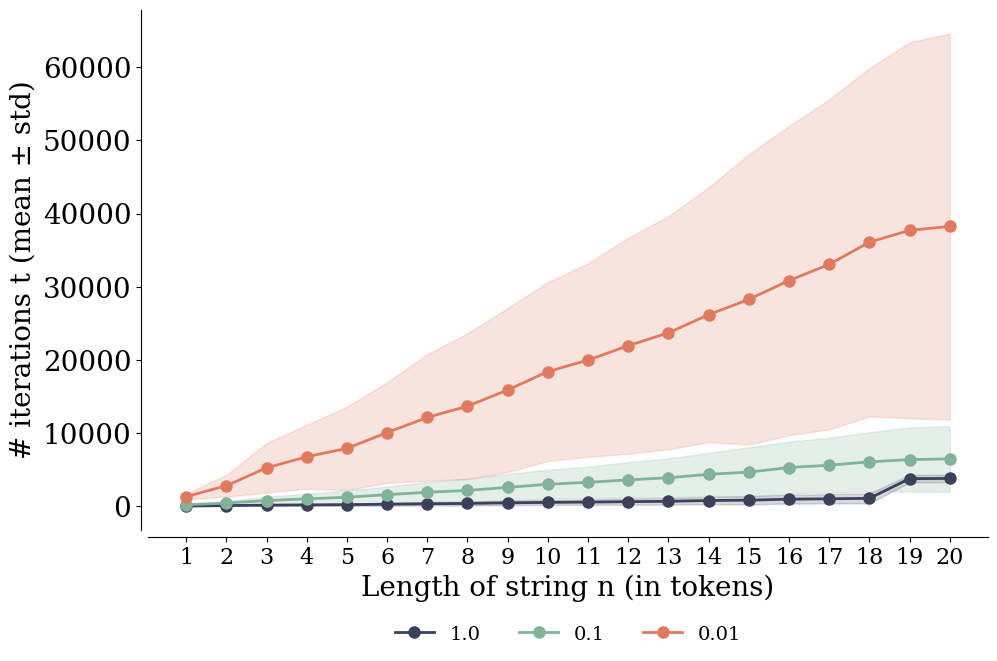

In [156]:
dataset_type = 'meaningful'
optimizer = 'SGD'
layer = 6
learning_rates = df[df['optimizer'] == optimizer]['learning_rate'].unique().tolist()

# filter dataframe based on dataset_type and optimizer 
df_exp_8_1 = df[(df['dataset_type'] == dataset_type) & (df['optimizer'] == optimizer) & (df['layer'] == layer)]
df_exp_8_1.head()

df_exp_8_1_results = {
    x: compute_statistics(df_exp_8_1[df_exp_8_1['learning_rate'] == x], indices=range(20), column_name='timesteps', reduce="sum")
    for x in learning_rates
}

plot_metrics(
    metrics=df_exp_8_1_results,
    xlabel="Length of string n (in tokens)",
    ylabel="# iterations t (mean ± std)",
    title="", integer_xticks=True
) 

Average accross all the 8 layers 

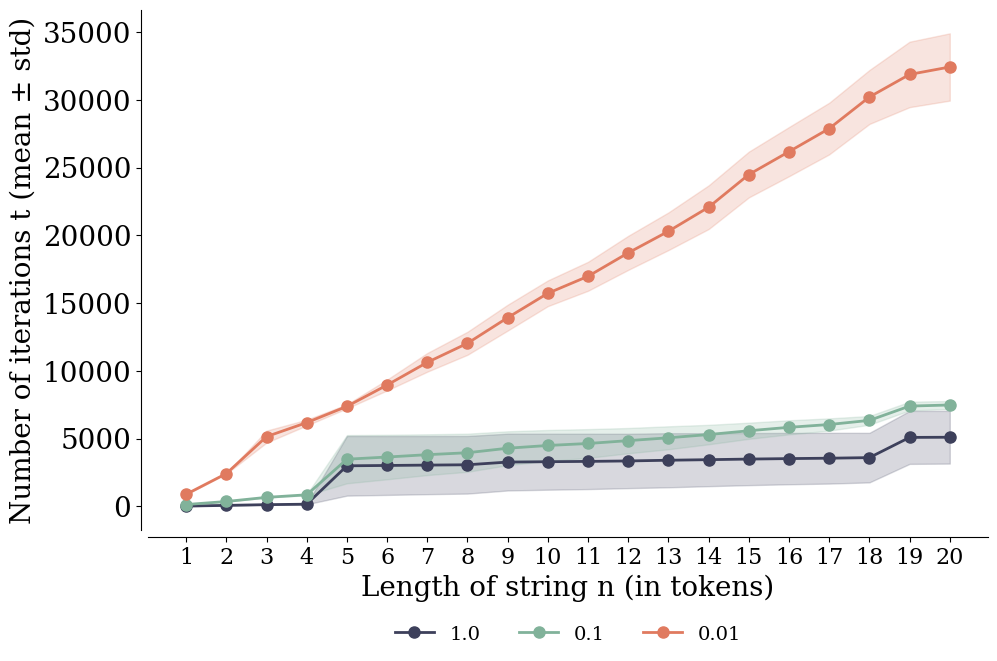

In [157]:
# now compute the same quantities but averaged for all layers from 1 to 8
df_exp_8_1_all_layers = df[(df['dataset_type'] == dataset_type) & (df['optimizer'] == optimizer)]
df_exp_8_1_all_layers_results = {
    x: compute_statistics(df_exp_8_1_all_layers[df_exp_8_1_all_layers['learning_rate'] == x], indices=range(20), column_name='timesteps', reduce="sum")
    for x in learning_rates
}
plot_metrics(
    metrics=df_exp_8_1_all_layers_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
)

We also keep printing this interesting outlier in the last layer hinting something for larger models

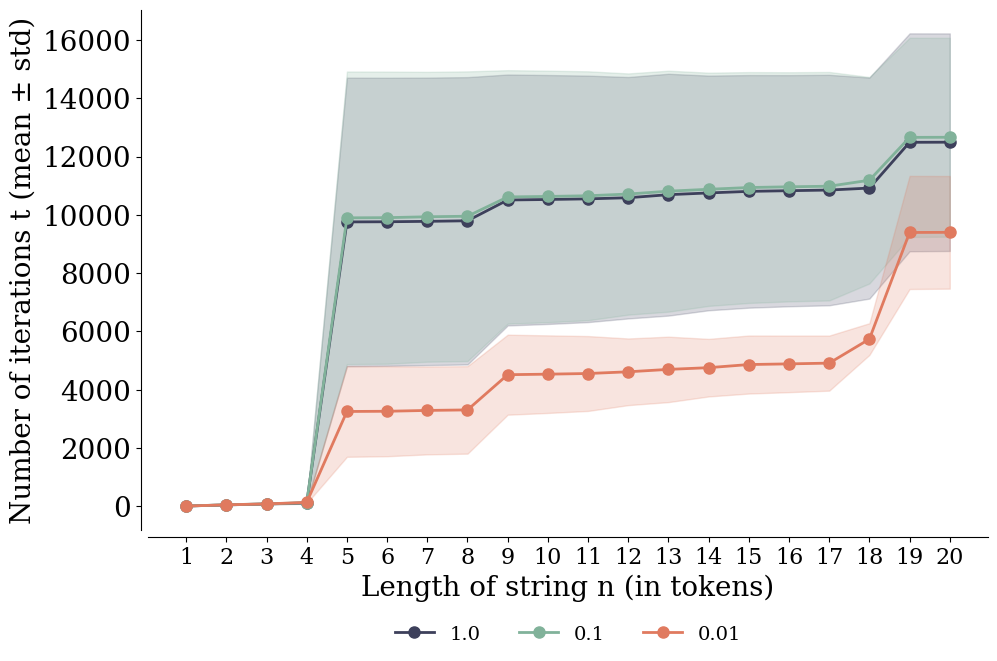

In [158]:
dataset_type = 'meaningful'
optimizer = 'SGD'
layer = 8
learning_rates = df[df['optimizer'] == optimizer]['learning_rate'].unique().tolist()

# filter dataframe based on dataset_type and optimizer 
df_exp_8_1 = df[(df['dataset_type'] == dataset_type) & (df['optimizer'] == optimizer) & (df['layer'] == layer)]
df_exp_8_1.head()

df_exp_8_1_results = {
    x: compute_statistics(df_exp_8_1[df_exp_8_1['learning_rate'] == x], indices=range(20), column_name='timesteps',reduce="sum")
    for x in learning_rates
}

plot_metrics(
    metrics=df_exp_8_1_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
) 

### Experiment 8.2 

E8.2 show how the convergence rate change when you change the first order algorithm 

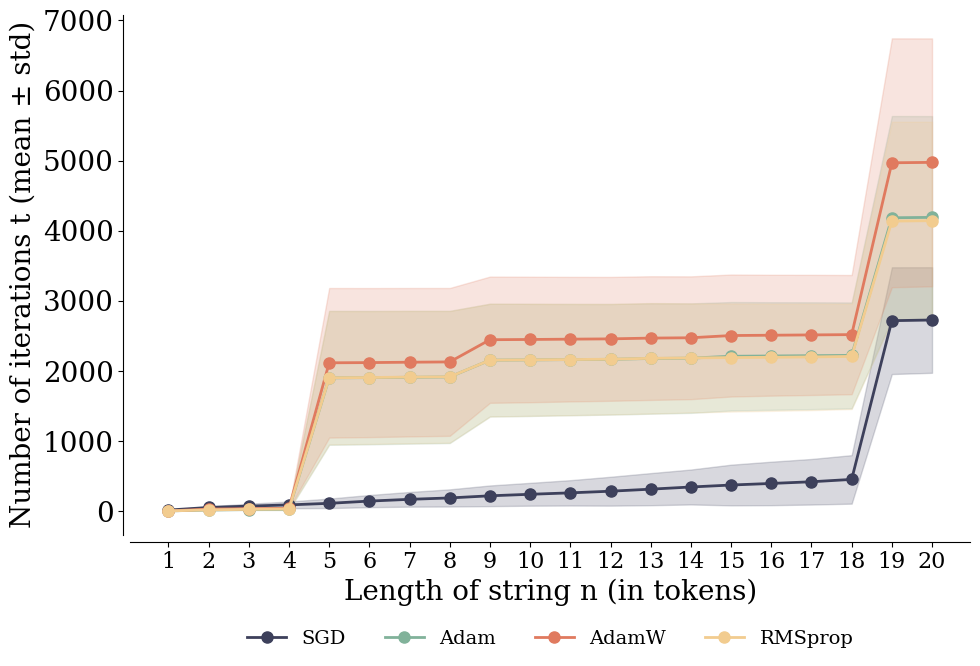

In [159]:
dataset_type = 'meaningful'
optimizers = ["SGD", "Adam", "AdamW", "RMSprop"]
layer = 4
learning_rates = 1

# filter dataframe based on dataset_type and optimizer
df_exp_8_2 = df[(df['dataset_type'] == dataset_type) & (df['layer'] == layer) & (df['learning_rate'] == learning_rates)]

df_exp_8_2_results = {
    x: compute_statistics(df_exp_8_2[df_exp_8_2['optimizer'] == x], indices=range(20), column_name='timesteps', reduce="sum")
    for x in optimizers
}
plot_metrics(
    metrics=df_exp_8_2_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
)

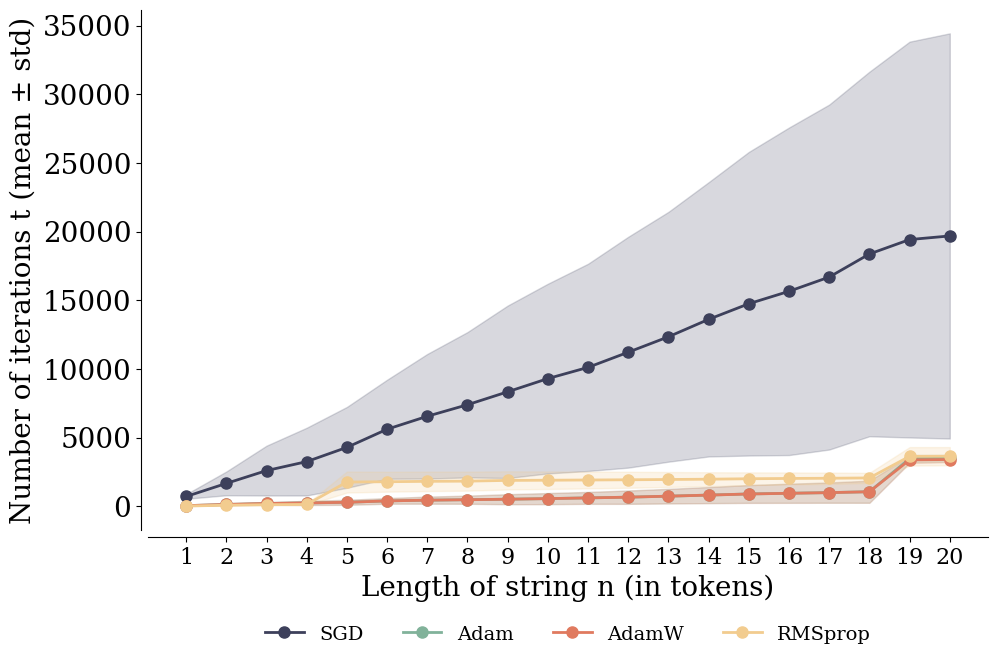

In [160]:
dataset_type = 'meaningful'
optimizers = ["SGD", "Adam", "AdamW", "RMSprop"]
layer = 4
learning_rates = 0.01

# filter dataframe based on dataset_type and optimizer
df_exp_8_2 = df[(df['dataset_type'] == dataset_type) & (df['layer'] == layer) & (df['learning_rate'] == learning_rates)]

df_exp_8_2_results = {
    x: compute_statistics(df_exp_8_2[df_exp_8_2['optimizer'] == x], indices=range(20), column_name='timesteps', reduce="sum")
    for x in optimizers
}
plot_metrics(
    metrics=df_exp_8_2_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
)

In [161]:
df[df["optimizer"] == "baseline"].head()

,dataset,index,layer,learning_rate,optimizer,token_length,match,inversion_time,timesteps,times,dataset_type
0,token_length_filtered_dataset.csv,0,4,1.0,baseline,20,True,7351.385433,50186_49690_50002_45509_50231_50255_49435_5025...,462.85_464.30_462.34_327.61_365.61_364.28_359....,meaningful
1,token_length_filtered_dataset.csv,1,4,1.0,baseline,20,True,7207.425212,49444_42919_49247_48716_50035_49748_49667_3579...,346.65_310.42_353.58_351.17_360.46_357.48_358....,meaningful
2,token_length_filtered_dataset.csv,2,4,1.0,baseline,20,True,7010.390019,49444_46110_49721_44105_50252_46154_50158_5025...,346.88_341.27_370.00_327.72_375.28_325.92_358....,meaningful
3,token_length_filtered_dataset.csv,3,4,1.0,baseline,20,True,6437.304603,43629_49316_43527_28567_35850_50252_38917_5022...,307.57_361.12_321.58_212.35_267.12_366.40_284....,meaningful
4,token_length_filtered_dataset.csv,4,4,1.0,baseline,20,True,6708.775810,43629_35900_44442_47687_46399_50246_49861_4845...,308.26_268.29_332.94_355.57_340.97_374.30_365....,meaningful


SGD: (np.float64(1.21785), np.float64(2.1767613564141057)), Adam: (np.float64(1.7577000000000003), np.float64(3.6093860912287505)), AdamW: (np.float64(2.0645000000000002), np.float64(4.358278291558109)), RMSprop: (np.float64(1.7419499999999999), np.float64(3.549506322872395)), Baseline: (np.float64(307.684), np.float64(56.24257026191696))


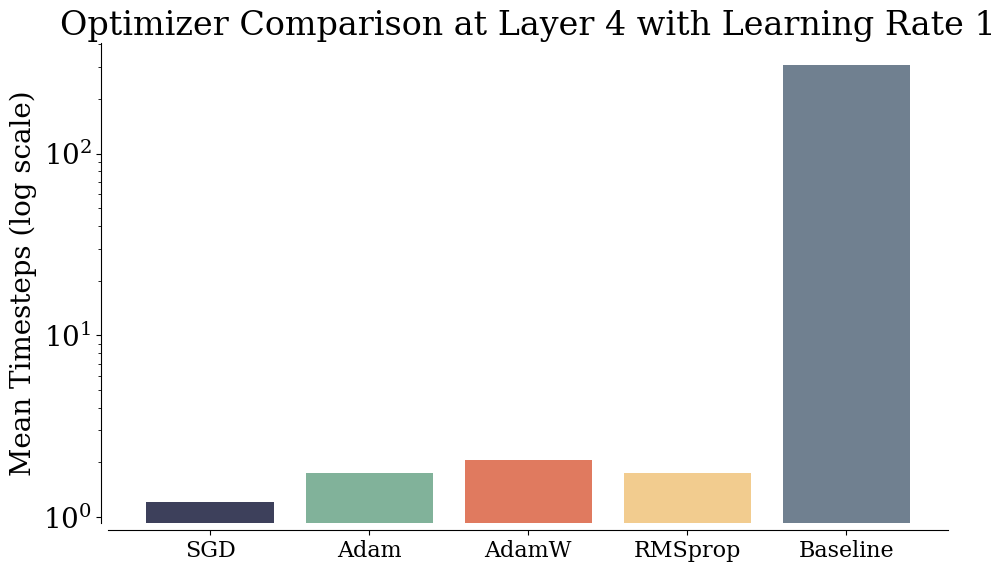

In [177]:
dataset_type = 'meaningful'
optimizers = ["SGD", "Adam", "AdamW", "RMSprop", "baseline"]
layer = 4
learning_rates = 1
df_exp_8_2 = df[(df['dataset_type'] == dataset_type) & (df['layer'] == layer) & (df['learning_rate'] == learning_rates)]
df_exp_8_2_results = {
    x: compute_statistics(df_exp_8_2[df_exp_8_2['optimizer'] == x], indices=range(20), column_name='times', reduce="mean")
    for x in optimizers
}
baseline = df_exp_8_2_results["baseline"][19] # mean, std
SGD = df_exp_8_2_results["SGD"][19] # mean, std
Adam = df_exp_8_2_results["Adam"][19] # mean, std
AdamW = df_exp_8_2_results["AdamW"][19] # mean, std
RMSprop = df_exp_8_2_results["RMSprop"][19] # mean, std

# represent them as a bar plot with names on the x-axis and mean values on the y-axis, with error bars for std

def plot_bar_with_error_bars_log(
    data: dict[str, tuple[float, float]],
    xlabel: str = None,
    ylabel: str = "Mean Timesteps",
    title: str = "Optimizer Comparison",
    figsize: tuple = (12, 8)
) -> None:
    """
    Plot a bar chart with error bars on a log y-axis in publication-quality style.

    Args:
        data:   Mapping from label to (mean, std) tuple.
        xlabel: Label for the x-axis.
        ylabel: Label for the y-axis.
        title:  Title of the plot.
        figsize: Figure size (width, height).
    """
    names = list(data.keys())
    means = [data[name][0] for name in names]
    stds = [data[name][1] for name in names]

    fig, ax = plt.subplots(figsize=figsize)
    # Use the same STYLES palette
    colors = STYLES[:len(names)]
    bars = ax.bar(
        names,
        means,
        # yerr=stds,
        capsize=5,
        color=colors
    )

    ax.set_yscale('log')
    # Labels and title
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_title(title, fontsize=24)

    # Tick customization
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=20)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # Adjust layout to center axes and prevent clipping
    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.3, top=0.9)
    plt.show()

plot_bar_with_error_bars_log(
    data={
        "SGD": SGD,
        "Adam": Adam,
        "AdamW": AdamW,
        "RMSprop": RMSprop,
        "Baseline": baseline
    },
    title="Optimizer Comparison at Layer 4 with Learning Rate 1",
    ylabel="Mean Timesteps (log scale)"
)

SGD: (np.float64(98.72999999999999), np.float64(174.02497617679288)), Adam: (np.float64(137.35999999999999), np.float64(281.8254126622051)), AdamW: (np.float64(160.41), np.float64(337.2187311918878)), RMSprop: (np.float64(136.72), np.float64(277.740403574593)), Baseline: (np.float64(45715.685), np.float64(2556.177531442212))


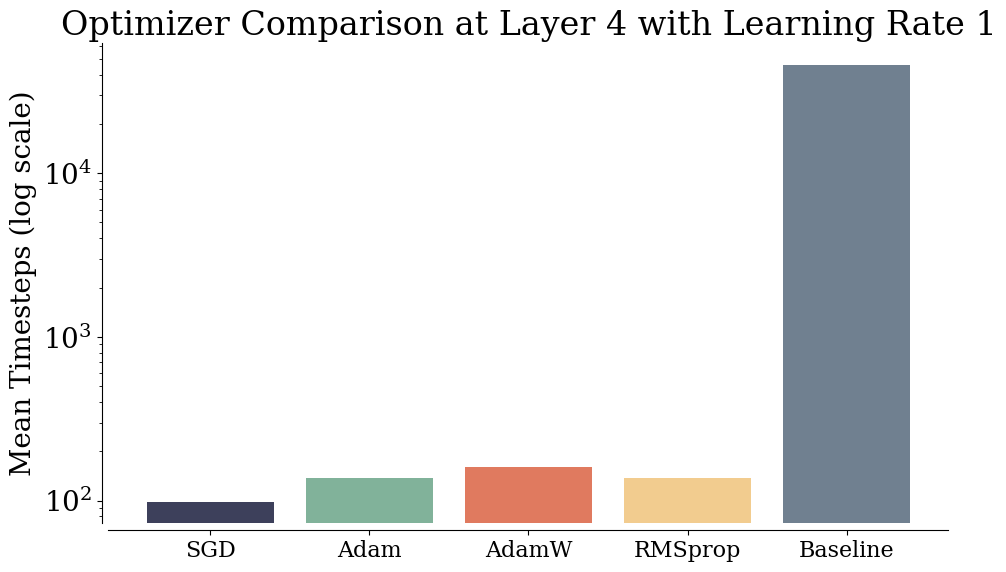

In [178]:
dataset_type = 'meaningful'
optimizers = ["SGD", "Adam", "AdamW", "RMSprop", "baseline"]
layer = 4
learning_rates = 1
df_exp_8_2 = df[(df['dataset_type'] == dataset_type) & (df['layer'] == layer) & (df['learning_rate'] == learning_rates)]
df_exp_8_2_results = {
    x: compute_statistics(df_exp_8_2[df_exp_8_2['optimizer'] == x], indices=range(20), column_name='timesteps', reduce="mean")
    for x in optimizers
}
baseline = df_exp_8_2_results["baseline"][19] # mean, std
SGD = df_exp_8_2_results["SGD"][19] # mean, std
Adam = df_exp_8_2_results["Adam"][19] # mean, std
AdamW = df_exp_8_2_results["AdamW"][19] # mean, std
RMSprop = df_exp_8_2_results["RMSprop"][19] # mean, std

plot_bar_with_error_bars_log(
    data={
        "SGD": SGD,
        "Adam": Adam,
        "AdamW": AdamW,
        "RMSprop": RMSprop,
        "Baseline": baseline
    },
    title="Optimizer Comparison at Layer 4 with Learning Rate 1",
    ylabel="Mean Timesteps (log scale)"
)

### Experiment 10.1

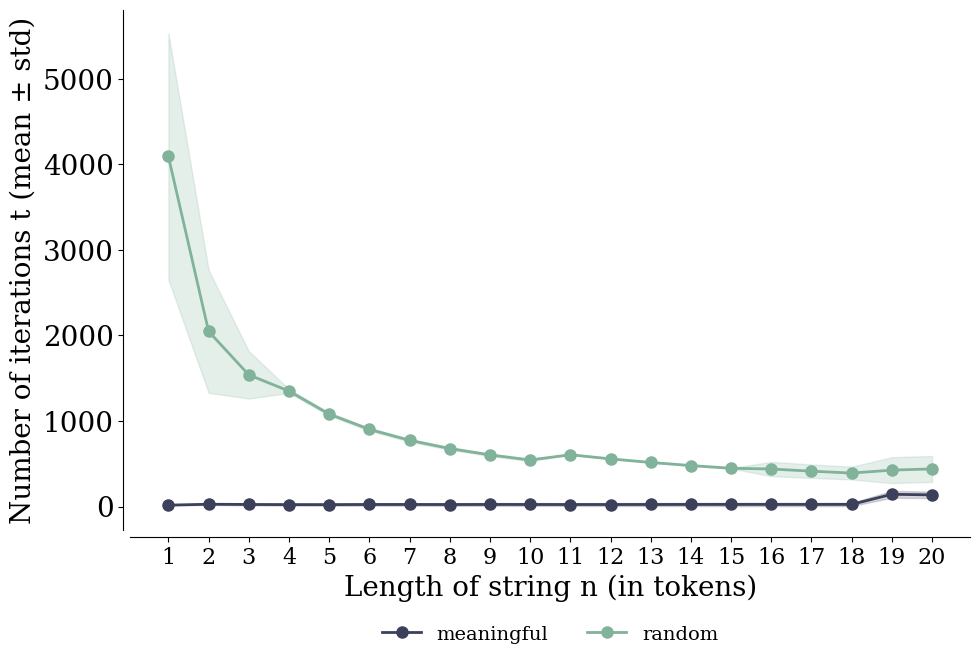

In [164]:
# two lists, layer 4, sgd, random/meaningful, lr=1


dataset_type = ['meaningful', 'random']
learning_rate = 1.0
optimizer = 'SGD'
layer = 4

df_exp10 = df[(df['learning_rate'] == learning_rate) & (df['optimizer'] == optimizer) & (df['layer'] == layer)]

df_exp10_results = {
    x: compute_statistics(df_exp10[df_exp10['dataset_type'] == x], indices=range(20), column_name='timesteps', reduce="mean")
    for x in dataset_type
}

plot_metrics(
    metrics=df_exp10_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
) 

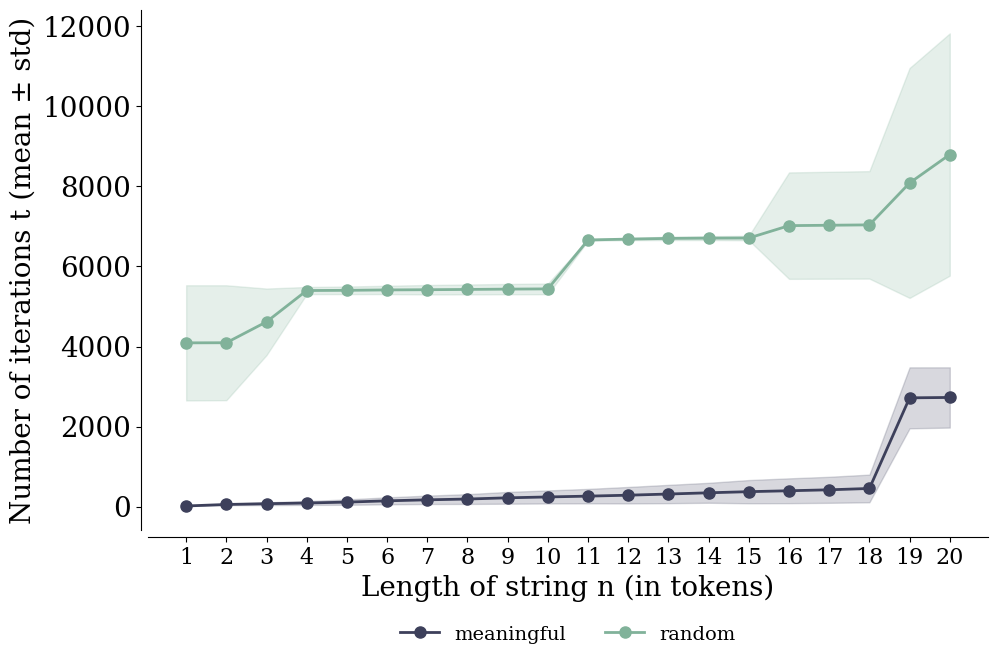

In [165]:
df_exp10_results = {
    x: compute_statistics(df_exp10[df_exp10['dataset_type'] == x], indices=range(20), column_name='timesteps', reduce="sum")
    for x in dataset_type
}

plot_metrics(
    metrics=df_exp10_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
) 

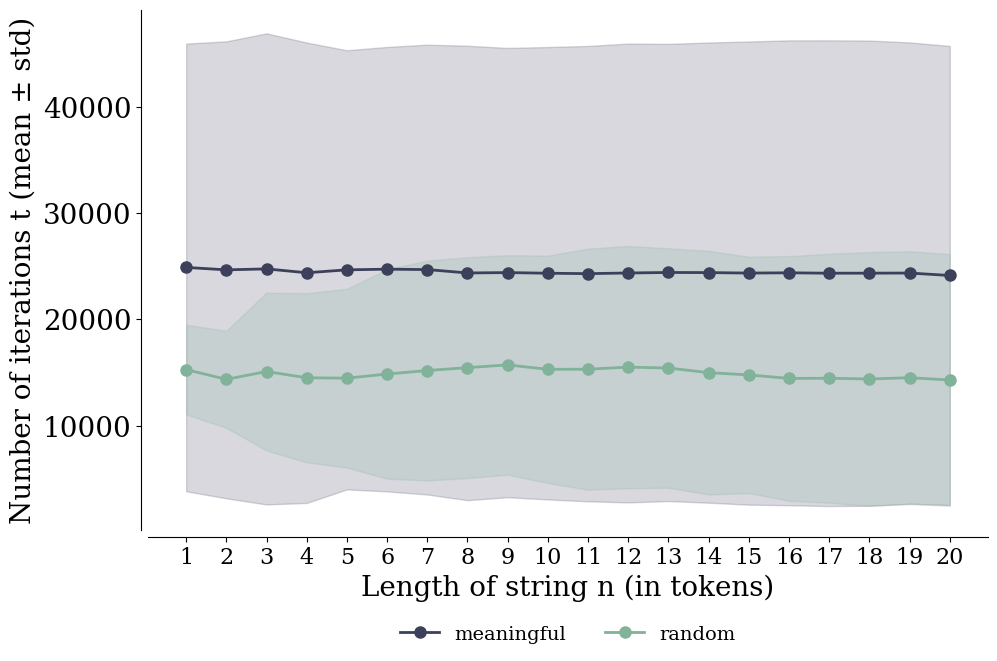

In [166]:
dataset_type = ['meaningful', 'random']
learning_rate = 1.0
optimizer = 'baseline'
layer = 4

df_exp10 = df[(df['learning_rate'] == learning_rate) & (df['optimizer'] == optimizer) & (df['layer'] == layer)]

df_exp10_results = {
    x: compute_statistics(df_exp10[df_exp10['dataset_type'] == x], indices=range(20), column_name='timesteps', reduce="mean")
    for x in dataset_type
}

plot_metrics(
    metrics=df_exp10_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
) 

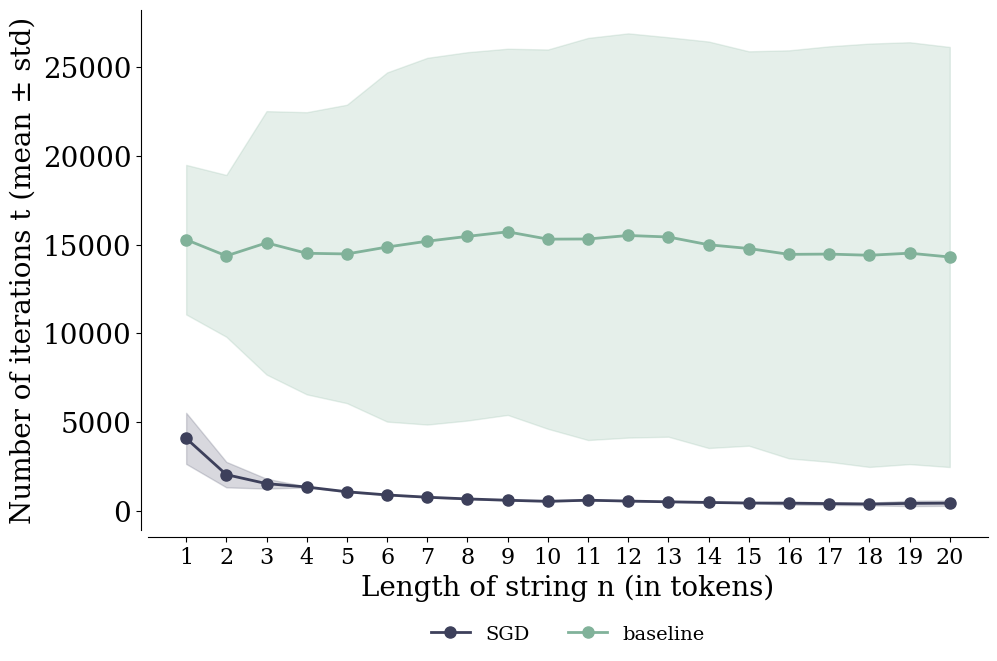

In [167]:
dataset_type = 'random'
learning_rate = 1.0
optimizer = ['SGD', 'baseline']
layer = 4

df_exp10 = df[(df['learning_rate'] == learning_rate) & (df['dataset_type'] == dataset_type) & (df['layer'] == layer)]

df_exp10_results = {
    x: compute_statistics(df_exp10[df_exp10['optimizer'] == x], indices=range(20), column_name='timesteps', reduce="mean")
    for x in optimizer
}

plot_metrics(
    metrics=df_exp10_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True,
    y_logscale=False
) 

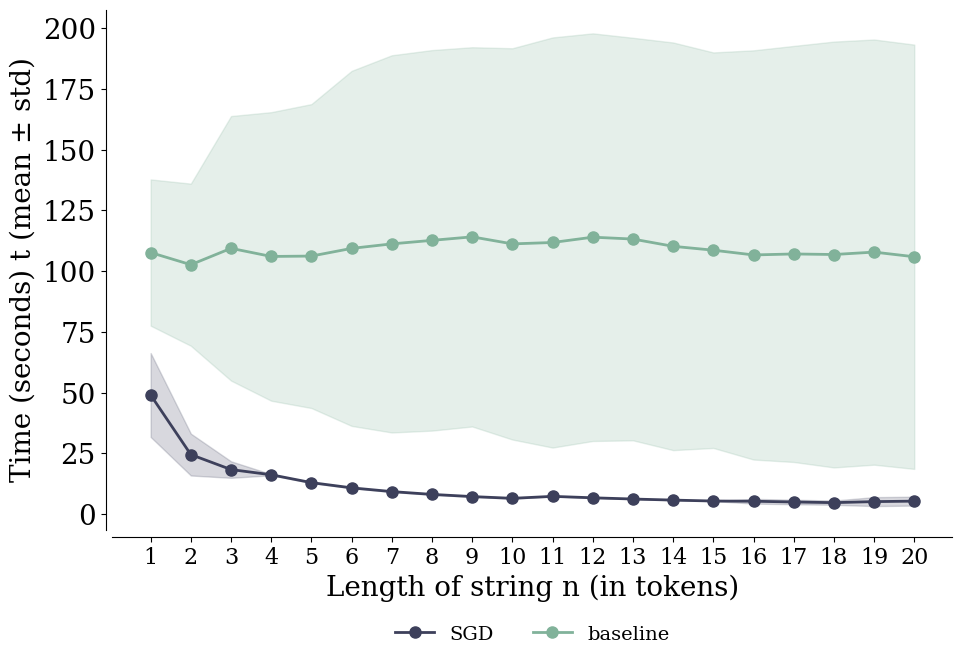

In [168]:
df_exp10_results = {
    x: compute_statistics(df_exp10[df_exp10['optimizer'] == x], indices=range(20), column_name='times', reduce="mean")
    for x in optimizer
}

plot_metrics(
    metrics=df_exp10_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Time (seconds) t (mean ± std)",
    title="", integer_xticks=True,
    y_logscale=False
) 

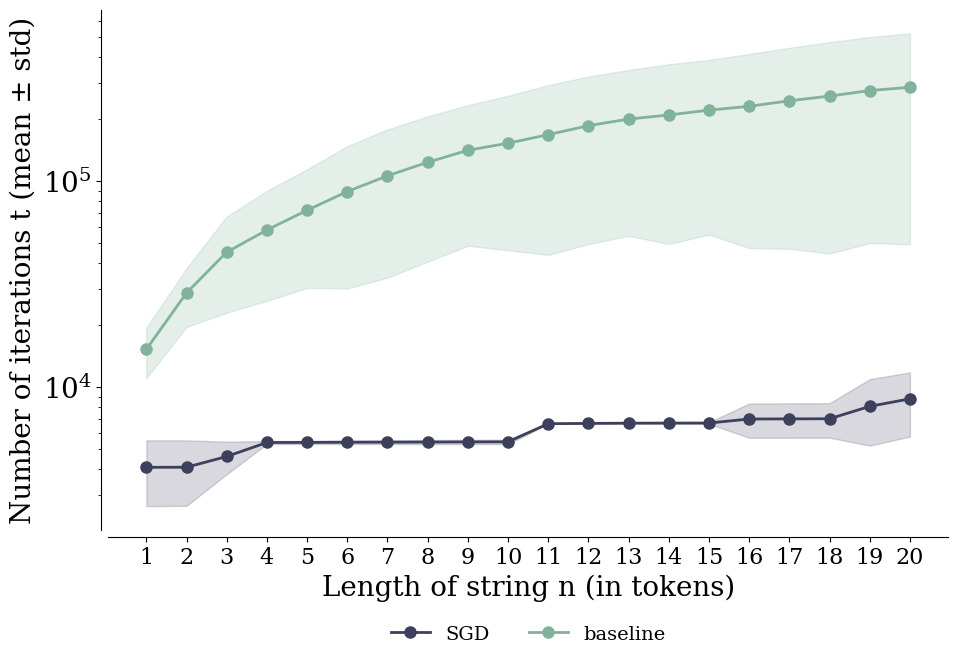

In [169]:
df_exp10_results = {
    x: compute_statistics(df_exp10[df_exp10['optimizer'] == x], indices=range(20), column_name='timesteps', reduce="sum")
    for x in optimizer
}

plot_metrics(
    metrics=df_exp10_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True,
    y_logscale=True
) 

### Experiment 11

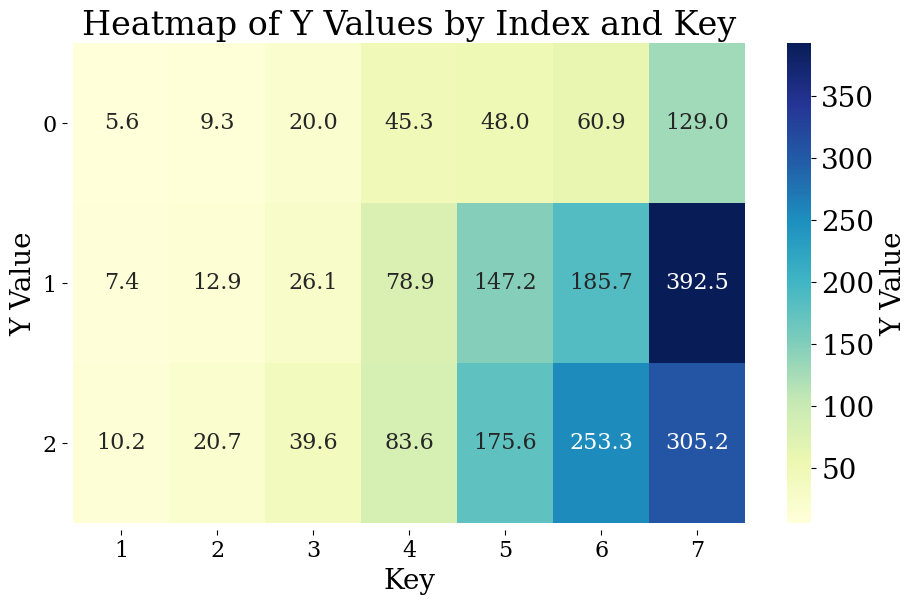

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns

dataset_type = 'meaningful'
learning_rate = 1.0
optimizer = 'SGD'
layer = np.arange(7) + 1

# indices = np.array(range(0, 20, 5))
# indices = np.array(range(18))
indices = np.array([4, 9, 14])

df_exp10 = df[(df['learning_rate'] == learning_rate) & (df['dataset_type'] == dataset_type) & (df['optimizer'] == optimizer)]

df_exp10_results = {
    x: compute_statistics(df_exp10[df_exp10['layer'] == x], indices=indices, column_name='timesteps', reduce="sum")
    for x in layer
}

summary = {}
for key, values in df_exp10_results.items():
    for i, (x, y) in enumerate(values):
        if i not in summary:
            summary[i] = {}
        summary[i][key] = y

df111 = pd.DataFrame(summary).T.sort_index()

def plot_heatmap(
    df,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    cmap=None,
    figsize: tuple = (12, 8)
) -> None:
    """
    Plot a styled heatmap using the custom discrete palette.
    """
    import seaborn as sns

    # Use default STYLES colormap if none provided
    cmap_to_use = cmap if cmap is not None else DEFAULT_CMAP

    fig, ax = plt.subplots(figsize=figsize)
    heatmap = sns.heatmap(
        df,
        annot=True,
        fmt=".1f",
        cmap=cmap_to_use,
        annot_kws={"fontsize": 16, "fontfamily": "serif"},
        cbar_kws={"label": ylabel}
    )

    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(20)
    cbar.ax.tick_params(labelsize=20)

    if title:
        ax.set_title(title, fontsize=24)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=20)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))

    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.3, top=0.9)
    plt.show()
    
plot_heatmap(
    df111,
    title="Heatmap of Y Values by Index and Key",
    xlabel="Key",
    ylabel="Y Value",
    cmap="YlGnBu"
)


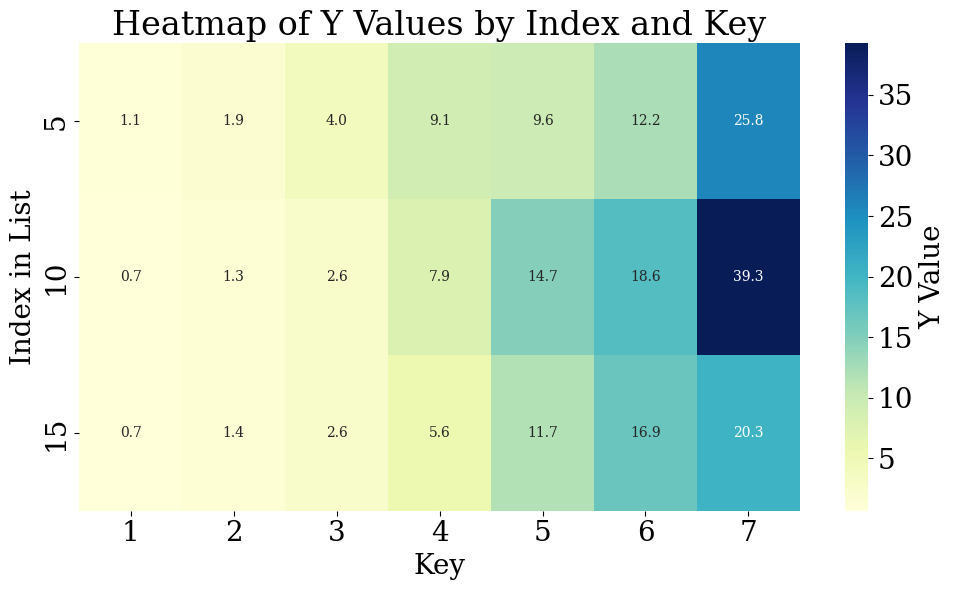

In [171]:
df_exp10 = df[(df['learning_rate'] == learning_rate) & (df['dataset_type'] == dataset_type) & (df['optimizer'] == optimizer)]

df_exp10_results = {
    x: compute_statistics(df_exp10[df_exp10['layer'] == x], indices=indices, column_name='timesteps', reduce="mean")
    for x in layer
}

summary = {}
for key, values in df_exp10_results.items():
    for i, (x, y) in enumerate(values):
        if i not in summary:
            summary[i] = {}
        summary[i][key] = y

df111 = pd.DataFrame(summary).T.sort_index()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df111, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Y Value'}, yticklabels=indices + 1)
plt.title("Heatmap of Y Values by Index and Key")
plt.xlabel("Key")
plt.ylabel("Index in List")
plt.tight_layout()
plt.show()


### Lol

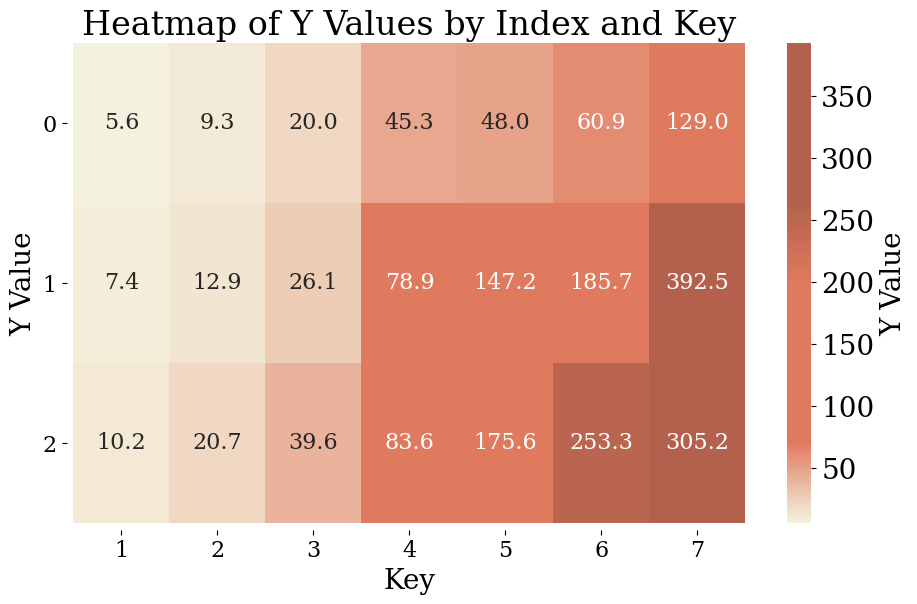

In [205]:
import matplotlib.pyplot as plt
import numpy as np
import shutil
from matplotlib.colors import LinearSegmentedColormap
from utils.metrics import _agg_metric

# Define the custom color palette
color_dict = {
    "Eggshell": "#f4f1de",
    "Burnt sienna": "#e07a5f",
    "Delft Blue": "#3d405b",
    "Cambridge blue": "#81b29a",
    "Sunset": "#f2cc8f",
}
# Styles order to match grouped-bar conventions
STYLES = [
    color_dict["Cambridge blue"],
    color_dict["Burnt sienna"],
    color_dict["Sunset"],
    color_dict["Delft Blue"],
    color_dict["Eggshell"],
]
# Default discrete colormap from STYLES
# Continuous colormap from Burnt sienna to Eggshell

DARK_BURNTSIENNA = "#b3614c"  # ~20% darker than #e07a5f

DEFAULT_CMAP = LinearSegmentedColormap.from_list(
    "burnt_sienna_to_eggshell",
    [color_dict["Eggshell"], color_dict["Burnt sienna"], color_dict["Burnt sienna"], color_dict["Burnt sienna"], DARK_BURNTSIENNA, DARK_BURNTSIENNA, DARK_BURNTSIENNA],
    N=256
)


# Check for LaTeX availability and configure text rendering
usetex_available = shutil.which('latex') is not None
plt.rcParams['text.usetex'] = usetex_available
if not usetex_available:
    plt.rcParams['text.usetex'] = False
    print("Warning: LaTeX not found, falling back to Matplotlib mathtext.")

# Global style settings
plt.rcParams.update({
    "font.family": "serif",
    "axes.titlesize": 24,
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 16,
})

def _rename(name: str, rename_dict: dict = None) -> str:
    """
    Rename a metric name based on a provided dictionary.
    """
    return rename_dict.get(name, name) if rename_dict else name


def plot_metrics(
    metrics,
    fill_between: bool = True,
    rename: dict = None,
    xlabel: str = None,
    ylabel: str = None,
    title: str = None,
    figsize: tuple = (12, 8),
    integer_xticks: bool = False,
    y_logscale: bool = False,
    xticks: list = None,
    yticks: list = None
):
    """
    Plot aggregated metrics per layer with the custom palette and styling.
    """
    agg_metrics = {m: _agg_metric(metrics, m) for m in metrics}
    fig, ax = plt.subplots(figsize=figsize)

    for i, (metric_name, (mean, std)) in enumerate(agg_metrics.items()):
        x = np.arange(len(mean))
        color = STYLES[i % len(STYLES)]
        if fill_between:
            ax.fill_between(x, mean - std, mean + std, alpha=0.2, color=color)
        ax.plot(
            x, mean,
            label=_rename(metric_name, rename),
            color=color,
            marker='o',
            markersize=8,
            linewidth=2
        )

    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    if title:
        ax.set_title(title, fontsize=24)
    if y_logscale:
        ax.set_yscale('log')

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=20)
    if integer_xticks:
        ax.set_xticks(x)
        ax.set_xticklabels([str(i + 1) for i in x], fontsize=16)
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(agg_metrics),
        frameon=False,
        fontsize=14
    )

    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.25, top=0.9)
    plt.show()


def plot_heatmap(
    df,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    cmap=None,
    figsize: tuple = (12, 8)
) -> None:
    """
    Plot a styled heatmap using the custom discrete palette.
    """
    import seaborn as sns

    # Use default STYLES colormap if none provided
    cmap_to_use = cmap if cmap is not None else DEFAULT_CMAP

    fig, ax = plt.subplots(figsize=figsize)
    heatmap = sns.heatmap(
        df,
        annot=True,
        fmt=".1f",
        cmap=cmap_to_use,
        annot_kws={"fontsize": 16, "fontfamily": "serif"},
        cbar_kws={"label": ylabel}
    )

    cbar = heatmap.collections[0].colorbar
    cbar.ax.yaxis.label.set_size(20)
    cbar.ax.tick_params(labelsize=20)

    if title:
        ax.set_title(title, fontsize=24)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=20)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))

    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.3, top=0.9)
    plt.show()


def plot_bar_with_error_bars_log(
    data: dict[str, tuple[float, float]],
    xlabel: str = None,
    ylabel: str = "Mean Timesteps",
    title: str = "Optimizer Comparison",
    figsize: tuple = (12, 8)
) -> None:
    """
    Plot a bar chart with error bars on a log y-axis in publication-quality style.
    """
    names = list(data.keys())
    means = [data[name][0] for name in names]
    stds = [data[name][1] for name in names]

    fig, ax = plt.subplots(figsize=figsize)
    colors = STYLES[:len(names)]
    ax.bar(
        names,
        means,
        yerr=stds,
        capsize=5,
        color=colors
    )

    ax.set_yscale('log')
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_title(title, fontsize=24)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=20)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 5))
    ax.spines['left'].set_position(('outward', 5))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    fig.subplots_adjust(left=0.15, right=0.85, bottom=0.3, top=0.9)
    plt.show()


dataset_type = 'meaningful'
learning_rate = 1.0
optimizer = 'SGD'
layer = np.arange(7) + 1

# indices = np.array(range(0, 20, 5))
# indices = np.array(range(18))
indices = np.array([4, 9, 14])

df_exp10 = df[(df['learning_rate'] == learning_rate) & (df['dataset_type'] == dataset_type) & (df['optimizer'] == optimizer)]

df_exp10_results = {
    x: compute_statistics(df_exp10[df_exp10['layer'] == x], indices=indices, column_name='timesteps', reduce="sum")
    for x in layer
}

summary = {}
for key, values in df_exp10_results.items():
    for i, (x, y) in enumerate(values):
        if i not in summary:
            summary[i] = {}
        summary[i][key] = y

df111 = pd.DataFrame(summary).T.sort_index()
   
plot_heatmap(
    df111,
    title="Heatmap of Y Values by Index and Key",
    xlabel="Key",
    ylabel="Y Value",
    # cmap="inferno"
)
